In [1]:
# =============================
# FUNCTIONS for overlapping pulses 
# =============================
 
############## Bath parameters ##############
global Boltzmann, hbar, Temp
Boltzmann = 1.0
hbar = 1.0

from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip.solver import Result
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *

In [ ]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
from dataclasses import dataclass, field
from typing import List
from qutip import basis, ket2dm
import numpy as np

### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]

# TODO GET CONVERSION FACTOR FOR OMEGAS!!!
@dataclass
class SystemParameters:
    # =============================
    # Fundamental constants and system size
    # =============================
    hbar: float = 1.0  # Planck's constant (reduced), [fs^-1 cm^-1]
    N_atoms: int = 1   # Number of atoms (currently only N=1 supported)

    # =============================
    # Solver and model control
    # =============================
    ODE_Solver: str = "Paper_BR"  # ODE solver type: "Paper_eqs", "Paper_BR", or "ME"
    RWA_laser: bool = True        # Use rotating wave approximation (RWA) for laser interaction

    # =============================
    # Energy and transition parameters
    # =============================
    Delta: float = 200.0          # Energy splitting between excited states [cm^-1]
    omega_A: float = 16000.0      # Atomic transition frequency [cm^-1]
    mu_eg: float = 1.0            # Transition dipole moment (dimensionless or [D])

    omega_laser: float = 16000.0  # Laser frequency [cm^-1]

    # =============================
    # Laser field parameters
    # =============================
    E0: float = 1.0               # Amplitude of the laser field (controls Rabi frequency)
    E_freqs: List[float] = field(default_factory=lambda: [16000.0]*3)  # List of laser frequencies for each pulse
    E_amps: List[float] = field(default_factory=lambda: [1.0, 1.0, 0.1])  # List of amplitudes for each pulse

    # =============================
    # Rabi frequencies and detuning
    # =============================
    rabi_0: float = 0.0           # Rabi frequency for resonant drive
    delta_rabi: float = 0.0       # Detuning between laser and atomic transition
    rabi_gen: float = 0.0         # Generalized Rabi frequency (includes detuning)

    # =============================
    # Pulse and time grid parameters
    # =============================
    pulse_duration: float = 15.0  # Duration of each pulse [fs]
    Delta_ts: List[float] = field(default_factory=lambda: [7.5, 7.5, 7.5])  # Half-widths of each pulse [fs]

    # =============================
    # Decoherence and relaxation rates
    # =============================
    gamma_0: float = 1/300        # Population decay rate [1/fs]
    T2: float = 100.0             # Dephasing time [fs]
    gamma_phi: float = 1/100      # Pure dephasing rate [1/fs]
    Gamma: float = 0.0            # Total decoherence rate [1/fs]

    # =============================
    # Derived time scales
    # =============================
    t_max_L: float = 0.0          # Max time for laser period [fs]
    t_prd: float = 0.0            # Rabi oscillation period [fs]
    fine_spacing: float = 0.0     # Time step for simulation [fs]
    t_max_r: float = 0.0          # Max time for Rabi oscillation [fs]
    t_max: float = 0.0            # Max simulation time [fs]

    # =============================
    # Quantum states, operators, and lists
    # =============================
    atom_g: object = field(default_factory=lambda: basis(2, 0))  # Ground state |g>
    atom_e: object = field(default_factory=lambda: basis(2, 1))  # Excited state |e>
    psi_ini: object = field(init=False)      # Initial density matrix (ground state)
    SM_op: object = field(init=False)        # Lowering operator (transition operator)
    Dip_op: object = field(init=False)       # Dipole operator (SM_op + SM_op.dag())
    e_ops_list: list = field(init=False)     # List of operators for expectation values
    e_ops_labels: list = field(init=False)   # Labels for expectation value operators
    c_ops_list: list = field(init=False)     # List of collapse operators for decoherence

    def __post_init__(self):
        # =============================
        # Initialize quantum states and operators
        # =============================
        self.psi_ini = ket2dm(self.atom_g)  # Initial state: ground state density matrix
        self.SM_op   = self.mu_eg * (self.atom_g * self.atom_e.dag()).unit()  # Lowering operator
        self.Dip_op  = self.SM_op + self.SM_op.dag()  # Dipole operator

        # =============================
        # Operator lists for expectation values and collapse
        # =============================
        self.e_ops_list = [
            ket2dm(self.atom_g),                # Population in ground state
            self.atom_g * self.atom_e.dag(),    # Coherence |g><e|
            self.atom_e * self.atom_g.dag(),    # Coherence |e><g|
            ket2dm(self.atom_e),                # Population in excited state
        ]
        self.e_ops_labels = ["gg", "ge", "eg", "ee"]  # Labels for expectation values

        # Collapse operators for population decay and pure dephasing
        self.c_ops_list = [
            np.sqrt(self.Gamma) * self.SM_op if self.Gamma > 0 else 0 * self.SM_op,
            np.sqrt(self.gamma_phi) * ket2dm(self.atom_e) if self.gamma_phi > 0 else 0 * ket2dm(self.atom_e)
        ]

    def update_derived(self):
        """
        Update all derived parameters and operator lists based on the current physical and simulation parameters.
        Call this after changing any parameter to keep everything consistent.
        """
        # =============================
        # Update driving field frequencies and amplitudes
        # =============================
        self.E_freqs = [self.omega_laser] * 3
        self.E_amps  = [self.E0, self.E0, 1e-1 * self.E0]

        # =============================
        # Update decoherence and relaxation rates
        # =============================
        if hasattr(self, "T_2"):
            self.gamma_phi = 1 / self.T_2
        self.Gamma      = self.gamma_0 / 2 + self.gamma_phi

        # =============================
        # Update Rabi frequencies and detuning
        # =============================
        self.rabi_0     = self.mu_eg * self.E0 / self.hbar
        self.delta_rabi = self.omega_laser - self.omega_A
        self.rabi_gen   = np.sqrt(self.rabi_0 ** 2 + self.delta_rabi ** 2)

        # =============================
        # Update time scales for simulation
        # =============================
        self.t_max_L      = 6 * 2 * np.pi / self.omega_laser
        self.t_prd        = 2 * np.pi / self.rabi_gen if self.rabi_gen != 0 else 0.0
        self.fine_spacing = 0.01 * min(self.t_prd, self.pulse_duration) if self.t_prd > 0 else 0.01 * self.pulse_duration
        self.t_max_r      = max(200, 0.01 * self.t_prd) if self.t_prd > 0 else 200
        self.t_max        = self.t_max_r
        self.Delta_ts     = [self.pulse_duration / 2] * 3

        # =============================
        # Update quantum operators and lists if parameters changed
        # =============================
        self.SM_op   = self.mu_eg * (self.atom_g * self.atom_e.dag()).unit()
        self.Dip_op  = self.SM_op + self.SM_op.dag()
        self.e_ops_list = [
            ket2dm(self.atom_g),
            self.atom_g * self.atom_e.dag(),
            self.atom_e * self.atom_g.dag(),
            ket2dm(self.atom_e),
        ]
        self.c_ops_list = [
            np.sqrt(self.Gamma) * self.SM_op if self.Gamma > 0 else 0 * self.SM_op,
            np.sqrt(self.gamma_phi) * ket2dm(self.atom_e) if self.gamma_phi > 0 else 0 * ket2dm(self.atom_e)
        ]

In [3]:
# =============================
# EXAMPLES: How to use SystemParameters
# =============================

# 1. Create a default system (all default parameters)
params_default = SystemParameters()
print("Default E_freqs:", params_default.E_freqs)
print("Default E_amps:", params_default.E_amps)

# 2. Create a system with custom laser frequency and amplitude
params_custom = SystemParameters(
    omega_laser = 15500.0,
    E0          = 0.02,
    E_freqs     = [15500.0, 15500.0, 15500.0],
    E_amps      = [0.02, 0.02, 0.005],
    
)
print("Custom E_freqs:", params_custom.E_freqs)
print("Custom E_amps:", params_custom.E_amps)

# 3. Update derived parameters after changing a value
params_update = SystemParameters()
params_update.E0 = 0.05
params_update.update_derived() # update all dependent quantities
print("Updated E_amps after E0 change:", params_update.E_amps)

# 4. Access quantum operators and states
psi_ini = params_default.psi_ini         # initial density matrix
SM_op   = params_default.SM_op           # lowering operator
Dip_op  = params_default.Dip_op          # dipole operator
print("Initial state:", psi_ini)
print("Dipole operator:", Dip_op)

# 5. Use in a simulation (example: pass to a function)
def run_example_simulation(system: SystemParameters):
    print("Running simulation with omega_laser =", system.omega_laser)
    # ... your simulation code here ...

run_example_simulation(params_default)
run_example_simulation(params_custom)

# 6. Change decoherence rates and update
params_decay = SystemParameters()
params_decay.gamma_phi = 1/50
params_decay.update_derived()
print("Updated Gamma:", params_decay.Gamma)

# 7. Access operator lists for expectation values
for label, op in zip(params_default.e_ops_labels, params_default.e_ops_list):
    print(f"Operator {label}: {op}")

# =============================
# End of examples
# =============================

Default E_freqs: [16000.0, 16000.0, 16000.0]
Default E_amps: [1.0, 1.0, 0.1]
Custom E_freqs: [15500.0, 15500.0, 15500.0]
Custom E_amps: [0.02, 0.02, 0.005]
Updated E_amps after E0 change: [0.05, 0.05, 0.005000000000000001]
Initial state: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
Dipole operator: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]
Running simulation with omega_laser = 16000.0
Running simulation with omega_laser = 15500.0
Updated Gamma: 0.021666666666666667
Operator gg: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
Operator ge: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]]
Operator eg: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0.]
 [1. 0

In [4]:
# Define Pulse and PulseSequence classes for structured pulse handling

from dataclasses import dataclass, field
from typing import List

@dataclass
class Pulse:
    pulse_start_time: float
    pulse_half_width: float
    pulse_phase: float
    pulse_amplitude: float
    pulse_freq: float

@dataclass
class PulseSequence:
    pulses: list = field(default_factory=list)  # List of Pulse objects

    @staticmethod
    def from_args(
        curr: tuple,
        prev: tuple = None,
        preprev: tuple = None,
        pulse_freq: float = None,
        Delta_t: float = None,
        E_amps: list = None,
    ) -> "PulseSequence":
        """
        Factory method to create a PulseSequence from argument tuples and lists,
        using a single global pulse_freq and Delta_t for all pulses.

        Parameters:
            curr (tuple): (start_time, phase) for the current pulse
            prev (tuple, optional): (start_time, phase) for the previous pulse
            preprev (tuple, optional): (start_time, phase) for the earliest pulse
            pulse_freq (float): Frequency for all pulses
            Delta_t (float): Half-width for all pulses
            E_amps (list): List of amplitudes for each pulse

        Returns:
            PulseSequence: An instance containing up to three pulses
        """
        if pulse_freq is None or Delta_t is None or E_amps is None:
            raise ValueError("pulse_freq, Delta_t, and E_amps must all be provided.")

        pulses = []

        # Add the earliest pulse if provided (preprev)
        if preprev is not None:
            t0_preprev, phi_preprev = preprev
            pulses.append(Pulse(
                pulse_start_time=t0_preprev,
                pulse_phase=phi_preprev,
                pulse_half_width=Delta_t,
                pulse_amplitude=E_amps[0],
                pulse_freq=pulse_freq,
            ))

        # Add the previous pulse if provided (prev)
        if prev is not None:
            t0_prev, phi_prev = prev
            idx = 1 if preprev is not None else 0
            pulses.append(Pulse(
                pulse_start_time=t0_prev,
                pulse_phase=phi_prev,
                pulse_half_width=Delta_t,
                pulse_amplitude=E_amps[idx],
                pulse_freq=pulse_freq,
            ))

        # Always add the current pulse (curr)
        t0_curr, phi_curr = curr
        if preprev is not None and prev is not None:
            idx = 2
        elif preprev is not None or prev is not None:
            idx = 1
        else:
            idx = 0
        pulses.append(Pulse(
            pulse_start_time=t0_curr,
            pulse_phase=phi_curr,
            pulse_half_width=Delta_t,
            pulse_amplitude=E_amps[idx],
            pulse_freq=pulse_freq,
        ))

        return PulseSequence(pulses=pulses)

    def as_dict(self) -> dict:
        """
        Convert to dictionary format compatible with legacy code.

        Returns:
            dict: Dictionary with key "pulses" and a list of pulse parameter dicts
        """
        return {"pulses": [pulse.__dict__ for pulse in self.pulses]}

# =============================
# Example: How to use PulseSequence with the refactored functions
# =============================

# Define three example pulses
test_t_max = 40.0
test_fine_spacing = 0.1
test_times = np.arange(-10, test_t_max, test_fine_spacing)
test_pulse_phases = [np.pi / 2, 0, np.pi / 4]
test_pulse_half_width = 5.0
test_pulse_freq = 2 * np.pi * 1.0
test_pulse_amps = [2.0, 1.0, 0.1]
pulse1 = Pulse(
    pulse_start_time = test_times[0],
    pulse_half_width = test_pulse_half_width,
    pulse_phase      = test_pulse_phases[0],
    pulse_amplitude  = test_pulse_amps[0],
    pulse_freq       = test_pulse_freq
)
pulse2 = Pulse(
    pulse_start_time = test_times[-1]/2,
    pulse_half_width = test_pulse_half_width,
    pulse_phase      = test_pulse_phases[1],
    pulse_amplitude  = test_pulse_amps[1],
    pulse_freq       = test_pulse_freq
)
pulse3 = Pulse(
    pulse_start_time = test_times[-1]/1.2,
    pulse_half_width = test_pulse_half_width,
    pulse_phase      = test_pulse_phases[2],
    pulse_amplitude  = test_pulse_amps[2],
    pulse_freq       = test_pulse_freq
)

# Create a PulseSequence
pulse_seq = PulseSequence(pulses=[pulse1, pulse2, pulse3])

def pulse_envelope(t: float, pulse_seq: PulseSequence) -> float:
    """
    Calculate the combined envelope of multiple pulses at time t using PulseSequence.
    """
    if not isinstance(pulse_seq, PulseSequence):
        raise TypeError("pulse_seq must be a PulseSequence instance.")

    envelope = 0.0
    for pulse in pulse_seq.pulses:
        t0          = pulse.pulse_start_time
        Delta_width = pulse.pulse_half_width
        if Delta_width is None or Delta_width <= 0:
            continue
        if t0 is None:
            continue
        if t0 <= t <= t0 + 2 * Delta_width:
            arg = np.pi * (t - (t0 + Delta_width)) / (2 * Delta_width)
            envelope += np.cos(arg) ** 2
    return envelope

def E_pulse(t: float, pulse_seq: PulseSequence) -> complex:
    """
    Calculate the total electric field at time t for a set of pulses (envelope only, no carrier), using PulseSequence.
    """
    if not isinstance(pulse_seq, PulseSequence):
        raise TypeError("pulse_seq must be a PulseSequence instance.")

    E_total = 0.0 + 0.0j
    for pulse in pulse_seq.pulses:
        phi = pulse.pulse_phase
        E0  = pulse.pulse_amplitude
        if phi is None or E0 is None:
            continue
        envelope = pulse_envelope(t, PulseSequence([pulse])) # use pulse_envelope for each pulse
        E_total += E0 * envelope * np.exp(-1j * phi)
    return E_total / 2.0

def Epsilon_pulse(t: float, pulse_seq: PulseSequence) -> complex:
    """
    Calculate the total electric field at time t for a set of pulses, including carrier oscillation, using PulseSequence.
    """
    if not isinstance(pulse_seq, PulseSequence):
        raise TypeError("pulse_seq must be a PulseSequence instance.")

    E_total = 0.0 + 0.0j
    for pulse in pulse_seq.pulses:
        omega = pulse.pulse_freq
        if omega is None:
            continue
        E_field = E_pulse(t, PulseSequence([pulse])) # use E_pulse for each pulse
        E_total += E_field * np.exp(-1j * (omega * t))
    return E_total

def plot_pulse_envelope(times: np.ndarray, pulse_seq: PulseSequence, ax=None):
    """
    Plot the combined pulse envelope over time for up to three pulses using PulseSequence.

    Parameters:
        times (np.ndarray): Array of time values.
        pulse_seq (PulseSequence): PulseSequence object containing pulses.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. Defaults to None.

    Returns:
        ax (matplotlib.axes.Axes): Axes object with the plot.
    """
    # Calculate the combined envelope over time
    envelope = [pulse_envelope(t, pulse_seq) for t in times]

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot combined envelope
    ax.plot(
        times,
        envelope,
        label=r"$\text{Combined Envelope}$",
        linestyle="solid",
        alpha=0.8,
        color="C0",
    )

    # Styles for up to three pulses
    linestyles = ["dashed", "dashdot", "dotted"]
    colors     = ["C1", "C2", "C3"]

    # Plot individual envelopes and annotations
    for idx, pulse in enumerate(pulse_seq.pulses[:3]):  # Up to 3 pulses
        t0          = pulse.pulse_start_time
        Delta_width = pulse.pulse_half_width

        # Compute individual pulse envelope
        individual_envelope = [
            np.cos(np.pi * (t - (t0 + Delta_width)) / (2 * Delta_width)) ** 2
            if t0 <= t <= t0 + 2 * Delta_width else 0.0
            for t in times
        ]

        ax.plot(
            times,
            individual_envelope,
            label=rf"$\text{{Pulse {idx + 1}}}$",
            linestyle=linestyles[idx % len(linestyles)],
            alpha=0.6,
            color=colors[idx % len(colors)],
        )

        # Annotate pulse key points
        ax.axvline(
            t0,
            linestyle="dotted",
            label=rf"$t_{{0, {idx + 1}}}$",
            alpha=0.4,
            color=colors[idx % len(colors)],
        )
        ax.axvline(
            t0 + Delta_width,
            linestyle="dashdot",
            label=rf"$t_{{0, {idx + 1}}} + \Delta_{{{idx + 1}}}$",
            alpha=0.6,
            color=colors[idx % len(colors)],
        )
        ax.axvline(
            t0 + 2 * Delta_width,
            linestyle="dotted",
            label=rf"$t_{{0, {idx + 1}}} + 2\Delta_{{{idx + 1}}}$",
            alpha=0.4,
            color=colors[idx % len(colors)],
        )

    # Final plot labeling
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel(r"Envelope Amplitude")
    ax.set_title(r"Pulse Envelopes for Up to Three Pulses")
    ax.legend(loc="upper right", fontsize="small")
    return ax

def El_field_3_pulses(times: np.ndarray, pulse_seq: PulseSequence, f=pulse_envelope):
    """
    Calculate the combined electric field for a PulseSequence.

    Parameters:
        times (np.ndarray): Time range for the pulses.
        pulse_seq (PulseSequence): PulseSequence object.
        f (function): Function to compute field (pulse_envelope, E_pulse, or Epsilon_pulse).

    Returns:
        np.ndarray: Electric field values.
    """
    # Calculate the electric field for each time
    E = np.array([f(t, pulse_seq) for t in times])
    # Normalize if not envelope
    if f != pulse_envelope and len(pulse_seq.pulses) > 0:
        E0 = pulse_seq.pulses[0].pulse_amplitude
        if E0 != 0:
            E *= 0.5 * E0
    return E

# Example usage:
#y0 = El_field_3_pulses(test_times, pulse_seq, f=pulse_envelope)
#y1 = El_field_3_pulses(test_times, pulse_seq, f=E_pulse)
#y2 = El_field_3_pulses(test_times, pulse_seq, f=Epsilon_pulse)
#plt.plot(test_times, y0, label="Envelope")
#plt.plot(test_times, y1, label="E_pulse")
#plt.plot(test_times, y2, label="Epsilon_pulse")
#plt.legend()

# 8. Use with PulseSequence and simulation functions
pulse_seq = PulseSequence([
    Pulse(0.0, 5.0, 0.0, 0.01, 16000.0),
    Pulse(10.0, 5.0, np.pi/2, 0.01, 16000.0),
    Pulse(20.0, 5.0, np.pi, 0.001, 16000.0)
])
# Example: compute_pulse_evolution(params_default.psi_ini, np.linspace(0, 50, 100), pulse_seq, system=params_default)


In [5]:
def H_int(t: float, 
          pulse_seq: PulseSequence, 
          system: SystemParameters,
) -> Qobj:
    """
    Define the interaction Hamiltonian for the system with multiple pulses using the PulseSequence class.

    Parameters:
        t (float): Time at which the interaction Hamiltonian is evaluated.
        pulse_seq (PulseSequence): PulseSequence object containing all pulse parameters.
        system (SystemParameters): System parameters.
        SM_op (Qobj): Lowering operator (system-specific).
        Dip_op (Qobj): Dipole operator (system-specific).

    Returns:
        Qobj: Interaction Hamiltonian at time t.
    """
    if not isinstance(pulse_seq, PulseSequence):
        raise TypeError("pulse_seq must be a PulseSequence instance.")

    use_rwa = system.RWA_laser
    SM_op = system.SM_op
    Dip_op = system.Dip_op
    
    if use_rwa:
        E_field = E_pulse(t, pulse_seq)  # Combined electric field under RWA
        H_int   = -(SM_op.dag() * E_field + SM_op * np.conj(E_field))  # RWA interaction Hamiltonian
    else:
        E_field = Epsilon_pulse(t, pulse_seq)  # Combined electric field with carrier
        H_int   = -Dip_op * (E_field + np.conj(E_field))  # Full interaction Hamiltonian

    return H_int

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


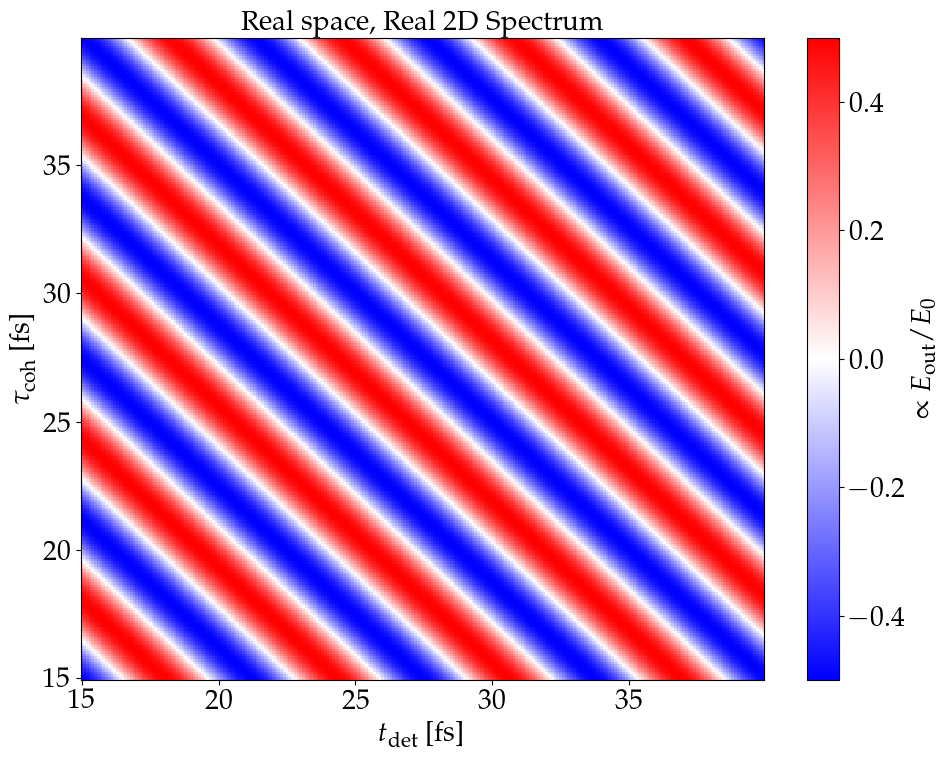

In [6]:
# ##########################
# independent of system
# ##########################
def plot_positive_color_map(
    datas: tuple,
    T_wait: float = np.inf,
    space: str = "real",
    type: str = "real",
    output_dir: str = None,
    ODE_Solver: str = None,
    positive: bool = False,
    safe: bool = False,
    use_custom_colormap: bool = False,
    section: tuple = None,  # (x_min, x_max, y_min, y_max)
):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T_wait (float): waiting time to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        output_dir (str, optional): Directory to save the plot.
        ODE_Solver (str, optional): Solver name for filename.
        positive (bool): Whether to use ONLY positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        use_custom_colormap (bool): Use custom colormap with white at zero.
        section (tuple, optional): (x_min, x_max, y_min, y_max) to zoom in.

    Returns:
        None
    """
    # =============================
    # Validate input
    # =============================
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas

    x    = np.real(x)
    y    = np.real(y)
    data = np.array(data, dtype=np.complex128)
    if np.abs(data).max() == 0:
        raise ValueError("Data array is all zeros, cannot normalize.")
    data = data / np.abs(data).max() # normalize

    if data.shape[1] != len(x):
        raise ValueError(
            f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]})."
        )
    if data.shape[0] != len(y):
        raise ValueError(
            f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]})."
        )

    # =============================
    # Set plot labels and colormap
    # =============================
    if space not in ("real", "freq"):
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")
    if space == "real":
        colormap = "viridis"
        title    = r"$\text{Real space}$"
        x_title  = r"$t_{\text{det}}$ [fs]"
        y_title  = r"$\tau_{\text{coh}}$ [fs]"
    else:
        colormap = "plasma"
        title    = r"$\text{Freq space}$"
        x_title  = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title  = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"

    if type not in ("real", "imag", "abs", "phase"):
        raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")
    if type == "real":
        title += r"$\text{, Real 2D Spectrum}$"
        data   = np.real(data)
    elif type == "imag":
        title += r"$\text{, Imag 2D Spectrum}$"
        data   = np.imag(data)
    elif type == "abs":
        title += r"$\text{, Abs 2D Spectrum}$"
        data   = np.abs(data)
        use_custom_colormap = False
    elif type == "phase":
        title += r"$\text{, Phase 2D Spectrum}$"
        data   = np.angle(data)

    if T_wait != np.inf:
        title += rf"$\ \text{{at }} T = {T_wait:.2f}$"

    # =============================
    # Restrict to positive quadrant if requested
    # =============================
    if positive:
        rows, cols = data.shape
        if rows % 2 != 0:
            data = data[:-1, :]
            y    = y[:-1]
        if cols % 2 != 0:
            data = data[:, :-1]
            x    = x[:-1]
        mid_x = len(x) // 2
        mid_y = len(y) // 2
        q1    = data[mid_y:, mid_x:]
        q3    = data[:mid_y, :mid_x]
        averaged_data = (q1 + np.flip(q3, axis=(0, 1))) / 2
        x     = x[mid_x:]
        y     = y[mid_y:]
        data  = averaged_data

    # =============================
    # Section cropping
    # =============================
    if section is not None:
        x_min, x_max, y_min, y_max = section
        x_indices = np.where((x >= x_min) & (x <= x_max))[0]
        y_indices = np.where((y >= y_min) & (y <= y_max))[0]
        x_indices = x_indices[x_indices < data.shape[1]]
        y_indices = y_indices[y_indices < data.shape[0]]
        data      = data[np.ix_(y_indices, x_indices)]
        x         = x[x_indices]
        y         = y[y_indices]

    # =============================
    # Custom colormap for zero-centered data
    # =============================
    norm = None
    if use_custom_colormap:
        vmin    = np.min(data)
        vmax    = np.max(data)
        vcenter = 0
        cmap    = plt.get_cmap("bwr")
        colors  = cmap(np.linspace(0, 1, 256))
        mid     = 128
        colors[mid] = [1, 1, 1, 1]  # white at center
        colormap = LinearSegmentedColormap.from_list("white_centered", colors)
        if vmin < vcenter < vmax:
            norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        else:
            print(f"Warning: Cannot use TwoSlopeNorm with vmin={vmin}, vcenter={vcenter}, vmax={vmax}. Using default normalization.")

    cbarlabel = r"$\propto E_{\text{out}} / E_{0}$"

    # =============================
    # Plotting
    # =============================
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        x, y, data,
        shading="auto",
        cmap=colormap,
        norm=norm,
    )
    plt.colorbar(label=cbarlabel)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # =============================
    # Save or show
    # =============================
    if safe and output_dir is not None:
        if not os.path.isdir(output_dir):
            raise ValueError(f"Output directory {output_dir} does not exist.")
        filename_parts = [
            f"M={N_atoms}",
            f"mua={mu_eg:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_A:.2f}",
            f"wL={omega_laser / omega_A:.1f}wa",
            f"rabigen={rabi_gen:.2f}= sqrt({rabi_0:.2f}^2+{delta_rabi:.2f}^2)",
            f"pos={positive}",
            f"space={space}",
        ]
        if ODE_Solver == "Paper_eqs":
            filename_parts.append(f"Paper_eqs")
        if space == "freq":
            filename_parts.append(f"type_{type}")
        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")
    plt.show()

# =============================
# TEST: plot_positive_color_map with cos(x)*sin(y)
# =============================
x      = test_times
y      = test_times
X, Y   = np.meshgrid(x, y)
data   = np.cos(X) * np.sin(Y)

plot_positive_color_map(
    datas=(x, y, data),
    space="real",
    type="real",
    positive=True,
    use_custom_colormap=True,
)
def get_expect_vals_with_RWA(states, times, e_ops, omega):
    """
    Calculate the expectation values in the result with RWA phase factors.

    Parameters:
        states= data.states (where data = qutip.Result): Results of the pulse evolution.
        times (list): Time points at which the expectation values are calculated.
        e_ops (list): the operators for which the expectation values are calculated
        omega (float): omega_laser (float): Frequency of the laser.
    Returns:
        list of lists: Expectation values for each operator of len(states).
    """
    if RWA_laser:
        # Apply RWA phase factors to each state
        states = [
            apply_RWA_phase_factors(state, time, omega)
            for state, time in zip(states, times)
        ]

    updated_expects = [np.real(expect(states, e_op)) for e_op in e_ops]
    return updated_expects
#CKECKED

def get_pulse_args(curr, prev=None, preprev=None):
    """
    Generate pulse arguments for multiple pulses based on the current time, phase, and pulse index.

    Parameters:
        curr = (t0_cur, phi_curr) (tuple of floats): starting time and phase kick of the current pulse
        prev = (t0_prev, phi_prev)  (tuple of floats, optional): Start time and phase kick of the previous pulse. Defaults to None.
        preprev = (t0_preprev, phi_preprev) (tuple of floats, optional): Start time and phase kick of the first pulse. Defaults to None.

    Returns:
        dict: Dictionary containing pulse parameters for the current and potentially previous.
    """
    # i (int): Index of the current pulse (0, 1, or 2).
    args = []
    i = 0

    if prev != None:
        i = 1
        t0_prev, phi_prev = prev
        if preprev != None:
            i = 2
            t0_preprev, phi_preprev = preprev
            args.append({
                "pulse_phase": phi_preprev,
                "pulse_start_time": t0_preprev,
                "pulse_freq": E_freqs[i-2],
                "pulse_half_width": Delta_ts[i-2],
                "pulse_amplitude": E_amps[i-2], 
            })
        args.append({
            "pulse_phase": phi_prev,
            "pulse_start_time": t0_prev,
            "pulse_freq": E_freqs[i-1],
            "pulse_half_width": Delta_ts[i-1],
            "pulse_amplitude": E_amps[i-1], 
        })
    
    t0_curr, phi_curr = curr
    args.append({
        "pulse_phase": phi_curr,
        "pulse_start_time": t0_curr,
        "pulse_freq": E_freqs[i],
        "pulse_half_width": Delta_ts[i],
        "pulse_amplitude": E_amps[i],
    })
    return {"pulses": args}

def get_tau_cohs_and_t_dets_for_T_wait(times: np.ndarray, T_wait: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the time arrays for tau_coh and t_det based on the waiting time T_wait and the time grid.

    Parameters:
        times (np.ndarray): 1D array of time points (must be sorted and equally spaced).
        T_wait (float): Waiting time.

    Returns:
        tuple: Arrays for coherence and detection times (tau_coh, t_det).
               Both have the same length.
    """
    # =============================
    # Validate input
    # =============================
    if times.size == 0:
        raise ValueError("Input 'times' array must not be empty.")
    if times.size == 1:
        return np.array([0.0]), np.array([0.0])
    spacing = times[1] - times[0]
    t_max   = times[-1]

    # =============================
    # Check T_wait validity
    # =============================
    if T_wait > t_max:
        print("Warning: T_wait >= t_max, no valid tau_coh/t_det values.")
        return np.array([]), np.array([])
    if np.isclose(T_wait, t_max):
        return np.array([0.0]), np.array([0.0])

    # =============================
    # Calculate tau_coh and t_det arrays
    # =============================
    tau_coh_max = t_max - T_wait
    if tau_coh_max < 0:
        return np.array([]), np.array([])

    tau_coh = np.arange(0, tau_coh_max + spacing/2, spacing) # include endpoint if possible
    t_det   = tau_coh + T_wait

    # =============================
    # Ensure t_det does not exceed t_max due to floating point
    # =============================
    valid_idx = t_det <= t_max + 1e-10
    tau_coh   = tau_coh[valid_idx]
    t_det     = t_det[valid_idx]

    return tau_coh, t_det

In [11]:
# ##########################
# dependent of system
# ##########################
def apply_RWA_phase_factors(rho, t, omega):
    """
    Apply time-dependent phase factors to the density matrix entries.

    Parameters:
        rho (Qobj): Density matrix (Qobj) to modify.
        omega (float): Frequency of the phase factor.
        t (float): Current time.

    Returns:
        Qobj: Modified density matrix with phase factors applied.
    """
    # Extract the density matrix as a NumPy array
    rho_array = rho.full()
    # print(rho.isherm)

    # Apply the phase factors to the specified elements
    phase_1 = np.exp(-1j * omega * t)  # e^(-i * omega * t)

    # Modify the elements
    rho_array[1, 0] *= phase_1  # rho_alpha_0 = sigma_alpha_0 * e^(-i * omega * t)
    rho_array[0, 1] *= np.conj(phase_1)
    rho_result = Qobj(rho_array, dims=rho.dims)
    # print(rho_array[0, 1], rho_array[1,0])

    #assert rho_result.isherm, "The resulting density matrix is not Hermitian."

    return rho_result

def Hamilton_tls(system: SystemParameters) -> Qobj:
    """
    Hamiltonian of a two-level system.

    Parameters:
        system (SystemParameters): System parameters containing hbar, omega_A, omega_laser, atom_e, and RWA_laser.

    Returns:
        Qobj: Hamiltonian operator of the two-level system.
    """
    # =============================
    # Build Hamiltonian in energy basis
    # =============================
    H0 = system.hbar * system.omega_A
    if system.RWA_laser:
        H0 -= system.hbar * system.omega_laser * ket2dm(system.atom_e) # shift in rotating frame
    return H0
# =============================
# "Paper_eqs" OWN ODE SOLVER
# =============================
def matrix_ODE_paper(
    t: float,
    pulse_seq: PulseSequence,
    system: SystemParameters
) -> Qobj:
    """
    Constructs the matrix L(t) for the equation drho_dt = L(t) * rho,
    where rho is the flattened density matrix. Uses gamma values from the provided system.

    Parameters:
        t (float): Time at which to evaluate the matrix.
        pulse_seq (PulseSequence): PulseSequence object for the electric field.
        system (SystemParameters): System parameters containing Gamma, gamma_0, and mu_eg.

    Returns:
        Qobj: Liouvillian matrix as a Qobj.
    """
    # Calculate the electric field using the pulse sequence
    Et      = E_pulse(t, pulse_seq)
    Et_conj = np.conj(Et)

    L = np.zeros((4, 4), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho_gg, 1: rho_ge, 2: rho_eg, 3: rho_ee

    # --- d/dt rho_ee ---
    L[3, 3] = -system.gamma_0
    L[3, 1] = 1j * Et * system.mu_eg
    L[3, 2] = -1j * Et_conj * system.mu_eg

    # --- d/dt rho_gg ---
    #L[0, 1] = -1j * Et * system.mu_eg
    #L[0, 2] = 1j * Et_conj * system.mu_eg
    L[0, :] += -1 * np.sum(L[[3], :], axis=0)  # Enforce trace conservation

    # --- d/dt rho_eg --- and  --- d/dt rho_ge ---
    L[2, 0] = 1j * Et * system.mu_eg
    L[2, 3] = -1j * Et * system.mu_eg

    L[1, :] = np.conj(L[2, :])

    L[2, 2] = -system.Gamma  # Decay term for coherence
    L[1, 1] = -system.Gamma  # Decay term for coherence

    return Qobj(L, dims=[[[2], [2]], [[2], [2]]])

def R_paper(system: SystemParameters) -> Qobj:
    """
    Constructs the Redfield Tensor R for the equation drho_dt = -i(Hrho - rho H) + R * rho,
    where rho is the flattened density matrix. Uses gamma values from the provided system.

    Parameters:
        system (SystemParameters): System parameters containing Gamma and gamma_0.

    Returns:
        Qobj: Redfield tensor as a Qobj.
    """
    R = np.zeros((4, 4), dtype=complex) # Redfield tensor initialization

    # --- d/dt rho_eg ---
    R[2, 2] = -system.Gamma  # Decay term for coherence
    # --- d/dt rho_ge ---
    R[1, 1] = -system.Gamma

    # --- d/dt rho_ee ---
    R[3, 3] = -system.gamma_0  # Decay term for population
    # --- d/dt rho_gg ---
    R[0, 3] =  system.gamma_0  # Ensures trace conservation

    return Qobj(R, dims=[[[2], [2]], [[2], [2]]])

def compute_pulse_evolution(
    psi_ini: Qobj,
    times: np.ndarray,
    pulse_seq: PulseSequence,
    system: SystemParameters = None,
) -> Result:
    """
    Compute the evolution of the system for a given pulse sequence.

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (np.ndarray): Time array for the evolution.
        pulse_seq (PulseSequence): PulseSequence object.
        system (SystemParameters): System parameters.

    Returns:
        qutip.Result: Result of the evolution.
    """
    # =============================
    # Use global parameters if not provided
    # =============================
    if system is None:
        raise ValueError("System parameters must be provided.")


    # Set solver options
    # progress_bar = "enhanced" if preprev != None and times[0] >= times[len(times) // 2] else ""
    options = {
        "store_states": True,
        "progress_bar": "",#progress_bar,
        "nsteps": 10000,  # Increase max number of steps per integration interval
    }

    # =============================
    # Choose solver and compute the evolution
    # =============================
    if system.ODE_Solver not in ["Paper_eqs", "ME", "Paper_BR"]:
        raise ValueError(f"Unknown ODE solver: {system.ODE_Solver}")

    if system.ODE_Solver == "Paper_eqs":
        # You need to adapt Liouville to accept pulse_seq and system if needed
        Liouville = QobjEvo(lambda t, args=None: matrix_ODE_paper(t, pulse_seq, system))
        result = mesolve(
            Liouville,
            psi_ini,
            times,
            options=options,
        )
    else:
        # Build Hamiltonian
        H_free = Hamilton_tls(system)
        H_int_evo = H_free + QobjEvo(lambda t, args=None: H_int(t, pulse_seq, system))
        c_ops = []
        if system.ODE_Solver == "Paper_BR":
            c_ops = [R_paper(system)]
        elif system.ODE_Solver == "ME":
            c_ops = system.c_ops_list
        
        result = mesolve(
            H_int_evo,
            psi_ini,
            times,
            c_ops=c_ops,
            options=options,
        )

        """
        # =============================
        # Split the evolution into two parts:
        # 1. With H_int for the pulse duration
        # 2. With H0 for the rest
        # =============================
        # Find the index where times = times[0] + 2*Delta_ts[0]
        last_pulse = pulse_seq.pulses[0]# MIGHT be wrong? -> -1
        t_pulse_end = last_pulse.pulse_start_time + 2 * last_pulse.pulse_half_width
        idx_split   = np.abs(times - t_pulse_end).argmin()

        times1 = times[:idx_split]
        if times1.size == 0:
            times1 = [last_pulse.pulse_start_time]
            

        result1 = mesolve(
            H_int_evo,
            psi_ini,
            times1,
            c_ops=[R_paper(system)],
            options=options,
        )

        # --- Second part: with H0 only ---
        # Use the last state as initial state for the second part
        psi_after_pulse = result1.states[-1]
        times2 = times[idx_split:]
        if len(times2) > 0:
            result2 = mesolve(
                H_free,
                psi_after_pulse,
                times2,
                c_ops=c_ops,
                options=options,
            )
            # Combine results
            all_states = list(result1.states) + list(result2.states)
            all_times = list(result1.times) + list(result2.times)
            options_full = options.copy()
            if "store_final_state" not in options_full:
                options_full["store_final_state"] = False
            if "store_states" not in options_full:
                options_full["store_states"] = True
            result = Result(e_ops=[], options=options_full)
            result.states = all_states
            result.times = all_times
            # Copy other attributes if needed
        else:
            result = result1"""

    return result

In [12]:
# ##########################
# independent of system
# ##########################
def check_the_solver(
    psi_ini: qutip.Qobj,
    times: np.ndarray,
    system: SystemParameters
) -> qutip.Result:
    """
    Checks the solver within the compute_pulse_evolution function
    with the provided psi_ini, times, and system.

    Parameters:
        psi_ini (qutip.Qobj): Initial quantum state.
        times (np.ndarray): Time array for the evolution.
        system (System): System object containing all relevant parameters, including e_ops_list.
        PulseSequence (type): The PulseSequence class to construct pulse sequences.

    Returns:
        qutip.Result: The result object from compute_pulse_evolution.
    """
    print(f"Checking '{system.ODE_Solver}' solver ")

    # =============================
    # INPUT VALIDATION
    # =============================
    if not hasattr(system, 'ODE_Solver'):
        raise AttributeError("system must have attribute 'ODE_Solver'")
    if not hasattr(system, 'e_ops_list'):
        raise AttributeError("system must have attribute 'e_ops_list'")
    if not isinstance(psi_ini, qutip.Qobj):
        raise TypeError("psi_ini must be a qutip.Qobj")
    if not isinstance(times, np.ndarray):
        raise TypeError("times must be a numpy.ndarray")
    if not isinstance(system.e_ops_list, list) or not all(isinstance(op, qutip.Qobj) for op in system.e_ops_list):
        raise TypeError("system.e_ops_list must be a list of qutip.Qobj")
    if len(times) < 2:
        raise ValueError("times must have at least two elements")

    # =============================
    # CONSTRUCT PULSE SEQUENCE (refactored)
    # =============================

    # Define pulse parameters
    phi_0      = np.pi / 2
    phi_1      = np.pi / 4
    phi_2      = 0
    t_start_0  = times[0]
    t_start_1  = times[-1]/2
    t_start_2  = times[-1]/1.1

    # Amplitudes, frequency, and half-width for all pulses
    E_amps     = [0.01, 0.01, 0.001]
    pulse_freq = system.omega_laser
    Delta_t    = 5.0

    # Use the from_args static method to construct the sequence
    pulse_seq = PulseSequence.from_args(
        curr=(t_start_2, phi_2),
        prev=(t_start_1, phi_1),
        preprev=(t_start_0, phi_0),
        pulse_freq=pulse_freq,
        Delta_t=Delta_t,
        E_amps=E_amps,
    )
    result = compute_pulse_evolution(
        psi_ini, times, pulse_seq, system=system
    )
    # =============================
    # CHECK THE RESULT
    # =============================
    if not isinstance(result, qutip.Result):
        raise TypeError("Result must be a qutip.Result object")
    if list(result.times) != list(times):
        raise ValueError("Result times do not match input times")
    if len(result.states) != len(times):
        raise ValueError("Number of output states does not match number of time points")

    # =============================
    # CHECK DENSITY MATRIX PROPERTIES
    # =============================
    strg = ""
    global time_cut
    time_cut = np.inf
    for index, state in enumerate(result.states):
        # Apply RWA phase factors if needed
        if getattr(system, 'RWA_laser', False):
            state = apply_RWA_phase_factors(state, times[index], omega=system.omega_laser)
        time = times[index]
        if not state.isherm:
            strg += f"Density matrix is not Hermitian after t = {time}.\n"
            print(state)
        eigvals = state.eigenenergies()
        if not np.all(eigvals >= -1e-3):  # allow for small numerical negative eigenvalues
            strg += f"Density matrix is not positive semidefinite after t = {time}: The lowest eigenvalue is {eigvals.min()}.\n"
            time_cut = time
        if not np.isclose(state.tr(), 1.0):
            strg += f"Density matrix is not trace-preserving after t = {time}: The trace is {state.tr()}.\n"
            time_cut = time
        if strg:
            strg += "Adjust your parameters!"
            print(strg)
            break
    else:
        print("Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.")

    return result, time_cut

def compute_two_dimensional_polarization(
    T_wait: float,
    phi_0: float,
    phi_1: float,
    times: np.ndarray,
    system,
    PulseSequence,
    plot_example: bool = False,
    **kwargs
):
    """
    Compute the two-dimensional polarization for a given waiting time (T_wait) and 
    the phases of the first and second pulses (phi_0, phi_1).

    Parameters:
        T_wait (float): Waiting time between the second and third pulses.
        phi_0 (float): Phase of the first pulse.
        phi_1 (float): Phase of the second pulse.
        times (np.ndarray): Time array.
        system: System object containing all relevant parameters.
        PulseSequence: The PulseSequence class to construct pulse sequences.
        plot_example (bool, optional): Whether to plot an example evolution.
        **kwargs: Additional keyword arguments.

    Returns:
        tuple: (t_det_vals, tau_coh_vals, data)
    """

    # get the symmetric times, tau_coh, t_det
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait=T_wait)

    # initialize the time domain Spectroscopy data tr(Dip_op * rho_final(tau_coh, t_det))
    data = np.zeros((len(tau_coh_vals), len(t_det_vals)), dtype=np.complex64)

    idx_start_0 = 0
    t_start_0   = times[idx_start_0]
    idx_end_0   = np.abs(times - (system.Delta_ts[0])).argmin()
    idx_start_1_max = np.abs(times - (tau_coh_vals[-1] - system.Delta_ts[1])).argmin()
    times_0 = times[: idx_start_1_max + 1]
    if times_0.size == 0:
        times_0 = times[idx_start_0:idx_end_0+1]

    # First pulse
    pulse_0 = (t_start_0, phi_0)
    pulse_seq_0 = PulseSequence([pulse_0], omega=system.omega_laser)
    data_0 = compute_pulse_evolution(system.psi_ini, times_0, pulse_seq_0, system=system)

    for tau_idx, tau_coh in enumerate(tau_coh_vals):
        idx_start_1 = np.abs(times - (tau_coh - system.Delta_ts[1])).argmin()
        t_start_1   = times[idx_start_1]
        idx_end_1   = np.abs(times - (tau_coh + system.Delta_ts[1])).argmin()
        rho_1       = data_0.states[idx_start_1]

        idx_start_2 = np.abs(times - (tau_coh + T_wait - system.Delta_ts[2])).argmin()
        idx_end_2   = np.abs(times - (tau_coh + T_wait + system.Delta_ts[2])).argmin()
        t_start_2   = times[idx_start_2]

        times_1 = times[idx_start_1:idx_start_2+1]
        if times_1.size == 0:
            times_1 = times[idx_start_1:idx_end_1+1]

        pulse_1 = (t_start_1, phi_1)
        pulse_seq_1 = PulseSequence([pulse_1, pulse_0], omega=system.omega_laser)
        data_1 = compute_pulse_evolution(rho_1, times_1, pulse_seq_1, system=system)

        idx_start_2_in_times_1 = np.abs(times_1 - t_start_2).argmin()
        rho_2 = data_1.states[idx_start_2_in_times_1]

        times_2 = times[idx_start_2:]
        if times_2.size == 0:
            times_2 = times[idx_start_2:idx_end_2+1]

        phi_2 = 0
        pulse_f = (t_start_2, phi_2)
        pulse_seq_f = PulseSequence([pulse_f, pulse_1, pulse_0], omega=system.omega_laser)
        data_f = compute_pulse_evolution(rho_2, times_2, pulse_seq_f, system=system)

        for t_idx, t_det in enumerate(t_det_vals):
            if t_idx + tau_idx < len(tau_coh_vals):
                actual_det_time = t_start_2 + system.Delta_ts[2] + t_det
                t_idx_in_times_2 = np.abs(times_2 - actual_det_time).argmin()

                if actual_det_time < time_cut:
                    rho_f = data_f.states[t_idx_in_times_2]
                    if system.RWA_laser:
                        rho_f = apply_RWA_phase_factors(rho_f, times_2[t_idx_in_times_2], omega=system.omega_laser)
                    value = expect(system.Dip_op, rho_f)
                    data[tau_idx, t_idx] = np.real(value)

                    if (t_idx == 0 and tau_idx == len(tau_coh_vals)//3 and plot_example):
                        data_1_expects = get_expect_vals_with_RWA(
                            data_0.states[:idx_start_1+1], data_0.times[:idx_start_1+1],
                            e_ops=system.e_ops_list+[system.Dip_op], omega=system.omega_laser
                        )
                        data_2_expects = get_expect_vals_with_RWA(
                            data_1.states[:idx_start_2_in_times_1+1], data_1.times[:idx_start_2_in_times_1+1],
                            e_ops=system.e_ops_list+[system.Dip_op], omega=system.omega_laser
                        )
                        data_f_expects = get_expect_vals_with_RWA(
                            data_f.states, data_f.times,
                            e_ops=system.e_ops_list+[system.Dip_op], omega=system.omega_laser
                        )
                        data_expectations = [
                            np.concatenate([data_1_expects[idx], data_2_expects[idx], data_f_expects[idx]])
                            for idx in range(len(system.e_ops_list)+1)
                        ]

                        Plot_example_evo(
                            times_0[:idx_start_1+1], times_1, times_2,
                            data_expectations,
                            pulse_seq_f,
                            tau_coh,
                            T_wait,
                        )

    return t_det_vals, tau_coh_vals, 1j * data  # because E ~ i*P
def Plot_example_evo(
    times_0: np.ndarray,
    times_1: np.ndarray,
    times_2: np.ndarray,
    datas: list,
    pulse_seq_f,
    tau_coh: float,
    T_wait: float,
    system,
):
    """
    Plot the evolution of the electric field and expectation values for a given tau_coh and T_wait.

    Parameters:
        times_0, times_1, times_2 (np.ndarray): Time ranges for the three pulses.
        datas (list): List of arrays of expectation values to plot.
        pulse_seq_f: PulseSequence object for the final pulse sequence.
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        system: System object containing all relevant parameters.

    Returns:
        None
    """
    # =============================
    # PREPARE TIME AXIS AND FIELD
    # =============================
    times_plot = np.concatenate([times_0, times_1, times_2])

    # Choose field function depending on RWA
    if getattr(system, "RWA_laser", False):
        field_func = E_pulse
    else:
        field_func = Epsilon_pulse

    # Compute total electric field using the pulse sequence
    E_total = np.zeros_like(times_plot, dtype=np.complex128)
    # =============================
    # Calculate total electric field for each pulse in the sequence
    # =============================
    # Calculate total electric field for the full pulse sequence at each time
    E_total = np.array([field_func(t, pulse_seq_f) for t in times_plot])

    # =============================
    # PLOTTING
    # =============================
    plt.figure(figsize=(14, 2 + 2 * len(datas)))

    # Plot electric field
    plt.subplot(len(datas) + 1, 1, 1)
    plt.plot(times_plot, np.real(E_total), color='C0', linestyle='solid', label=r"$\mathrm{Re}[E(t)]$")
    plt.plot(times_plot, np.imag(E_total), color='C1', linestyle='dashed', label=r"$\mathrm{Im}[E(t)]$")
    plt.ylabel(r"$E(t) / E_0$")
    plt.axvline(times_0[0] + system.Delta_ts[0], color='C2', linestyle='dashed', label=r"Pulse 1")
    plt.axvline(times_1[0] + system.Delta_ts[1], color='C3', linestyle='dashdot', label=r"Pulse 2")
    plt.axvline(times_2[0] + system.Delta_ts[2], color='C4', linestyle='dotted', label=r"Pulse 3")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    # Plot expectation values
    for idx, data in enumerate(datas):
        plt.subplot(len(datas) + 1, 1, idx + 2)
        if hasattr(system, "e_ops_labels") and idx < len(system.e_ops_labels):
            label = r"$\mathrm{Re}\langle" + system.e_ops_labels[idx] + r"\rangle$"
        else:
            label = r"$\mathrm{Re}\langle \mu \rangle$"
        plt.plot(times_plot, data, color=f"C{(idx+5)%10}", linestyle='solid', label=label)
        plt.axvline(times_0[0] + system.Delta_ts[0], color='C2', linestyle='dashed')
        plt.axvline(times_1[0] + system.Delta_ts[1], color='C3', linestyle='dashdot')
        plt.axvline(times_2[0] + system.Delta_ts[2], color='C4', linestyle='dotted')
        plt.ylabel(label)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.xlabel(r"$t\,/\,\mathrm{fs}$")
    plt.suptitle(
        rf"$\tau = {tau_coh:.2f}\,\mathrm{{fs}},\quad T = {T_wait:.2f}\,\mathrm{{fs}},\quad \mathrm{{Solver}}: {system.ODE_Solver}$"
    )
    plt.tight_layout()
    plt.show()

def extend_time_tau_axes(ts, taus, data, pad_rows=(0, 0), pad_cols=(0, 0)):
    """
    Extend the ts and taus axes and pad the data array accordingly.

    Parameters:
        ts (np.ndarray): Time axis (t).
        taus (np.ndarray): Tau axis (coherence time).
        data (np.ndarray): 2D data array.
        pad_rows (tuple): Padding for rows (before, after) along taus axis.
        pad_cols (tuple): Padding for columns (before, after) along ts axis.

    Returns:
        tuple: (extended_ts, extended_taus, padded_data)
    """
    # Pad the data array
    padded_data = np.pad(data, (pad_rows, pad_cols), mode='constant', constant_values=0)

    # Compute steps
    dt   = ts[1]   - ts[0]
    dtau = taus[1] - taus[0]

    # Extend axes
    extended_ts   = np.linspace(ts[0]   - pad_cols[0]*dt,   ts[-1]   + pad_cols[1]*dt,   padded_data.shape[1])
    extended_taus = np.linspace(taus[0] - pad_rows[0]*dtau, taus[-1] + pad_rows[1]*dtau, padded_data.shape[0])

    return extended_ts, extended_taus, padded_data

def compute_2d_fft_wavenumber(ts, taus, data):
    """
    Compute the 2D FFT of the data and convert axes to wavenumber units.

    Parameters:
        ts (np.ndarray): Time axis for detection.
        taus (np.ndarray): Time axis for coherence.
        data (np.ndarray): 2D data array.

    Returns:
        tuple: (nu_ts, nu_taus, s2d) where
            nu_ts (np.ndarray): Wavenumber axis for detection.
            nu_taus (np.ndarray): Wavenumber axis for coherence.
            s2d (np.ndarray): 2D FFT of the input data.
    """
    # Calculate frequency axes (cycle/fs)
    taufreqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))
    tfreqs   = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))

    # Convert to wavenumber units [10^4 cm⁻¹]
    nu_taus = taufreqs / 2.998 * 10
    nu_ts   = tfreqs / 2.998 * 10

    # 2D FFT: first over tau (axis=1), then over t (axis=0), take imaginary part
    s2d = np.fft.fftshift(
        np.fft.fft(
            np.fft.fft(
                np.imag(data),
                axis=1
            ),
            axis=0
        )
    )

    return nu_ts, nu_taus, s2d


In [13]:
# ##########################
# dependent of system
# ##########################

def sigma(E, Delta, E0=0):
    """
    Computes the function σ(E - E0) as shown in the image.

    Parameters:
    - E: Energy value or array of values
    - Delta: Full Width at Half Maximum (FWHM)
    - E0: Center energy (default is 0)

    Returns:
    - σ(E - E0): The value of the function at E
    """
    ln2       = np.log(2) # natural logarithm of 2
    prefactor = np.sqrt(ln2) / (np.sqrt(np.pi) * (Delta / 2)) # normalization factor
    exponent  = -((E - E0)**2 / ((Delta / 2)**2)) * ln2 # Gaussian exponent
    return prefactor * np.exp(exponent)
"""# =============================
# PLOT THE FUNCTION
# =============================

### Generate values for plotting
E_values = np.linspace(-10, 10, 500) # energy range
E0       = omega_A                       # center energy

### Calculate sigma values
sigma_values = sigma(E_values, Delta, E0)

### Plot the function
plt.figure(figsize=(10, 6))
plt.plot(E_values, sigma_values, label=rf"$\Delta = {Delta}, E_0 = {E0}$", color='C0', linestyle='solid')
plt.title(r"$\sigma(E - E_0)$ Function")
plt.xlabel(r"$E$")
plt.ylabel(r"$\sigma(E - E_0)$")
plt.legend()
plt.tight_layout()
plt.show()"""

def sample_from_sigma(N, Delta, E0, E_range=10):
    """
    Samples N values from a normalized σ(E) distribution using rejection sampling.

    Parameters:
    - N: number of samples
    - Delta: FWHM of the sigma distribution
    - E0: center of the distribution
    - E_range: range (in units of Delta) to sample from around E0

    Returns:
    - omega_ats: array of sampled omega values
    """
    # Define the sampling range
    E_min      = E0 - E_range * Delta
    E_max      = E0 + E_range * Delta
    E_vals     = np.linspace(E_min, E_max, 10000)
    sigma_vals = sigma(E_vals, Delta, E0)

    # Normalize sigma to use it as a probability density
    sigma_max  = np.max(sigma_vals)

    samples = []
    while len(samples) < N:
        E_try = np.random.uniform(E_min, E_max)
        y_try = np.random.uniform(0, sigma_max)
        if y_try < sigma(E_try, Delta, E0):
            samples.append(E_try)
    return np.array(samples)

def compute_many_polarizations(T_wait, phi_0, phi_1, N, E0, Delta, times, **kwargs):
    """
    Calls compute_two_dimensional_polarization N times for different omega_ats sampled from σ.

    Parameters:
    - N: number of simulations
    - Delta: FWHM for sigma distribution
    - phi_0, phi_1: laser phases
    - T_wait: delay
    - E0: center of the frequency distribution
    - **kwargs: any additional arguments for compute_two_dimensional_polarization

    Returns:
    - results: list of (t_det_vals, tau_coh_vals, data) tuples
    - omega_ats: list of sampled omega_ats used
    """
    omega_ats = sample_from_sigma(N, Delta, E0)
    results = []

    for omega in omega_ats:
        data = compute_two_dimensional_polarization(
            T_wait=T_wait,
            phi_0=phi_0,
            phi_1=phi_1,
            times=times,
            omega_at=omega,
            **kwargs
        )
        results.append(data[2])
    data_avg = np.mean(results, axis=0)
    # for the last one extract the times
    t_det_vals = data[0]
    tau_coh_vals = data[1]
    return t_det_vals, tau_coh_vals, data_avg, omega_ats
"""# Test the sampling function
Delta_test = Delta
E0_test = omega_A
samples = sample_from_sigma(100, Delta=Delta_test, E0=E0_test)

# Plot the results
E_vals = np.linspace(E0_test - 5 * Delta_test, E0_test + 5 * Delta_test, 1000)
sigma_vals = sigma(E_vals, Delta_test, E0_test)

plt.figure(figsize=(8, 4))
plt.hist(samples, bins=100, density=True, alpha=0.6, label='Sampled histogram')
plt.plot(E_vals, sigma_vals / np.trapz(sigma_vals, E_vals), 'r-', label=r'Normalized $\sigma$(E)')
plt.xlabel('E')
plt.ylabel('Probability Density')
plt.title(r'Rejection Sampling from $\sigma$(E)')
plt.legend()
plt.show()"""

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:106: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:106: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_179870/1291160030.py:21: SyntaxWarning: invalid escape sequence '\D'
  """# =============================
/tmp/ipykernel_179870/1291160030.py:106: SyntaxWarning: invalid escape sequence '\s'
  """# Test the sampling function


"# Test the sampling function\nDelta_test = Delta\nE0_test = omega_A\nsamples = sample_from_sigma(100, Delta=Delta_test, E0=E0_test)\n\n# Plot the results\nE_vals = np.linspace(E0_test - 5 * Delta_test, E0_test + 5 * Delta_test, 1000)\nsigma_vals = sigma(E_vals, Delta_test, E0_test)\n\nplt.figure(figsize=(8, 4))\nplt.hist(samples, bins=100, density=True, alpha=0.6, label='Sampled histogram')\nplt.plot(E_vals, sigma_vals / np.trapz(sigma_vals, E_vals), 'r-', label=r'Normalized $\\sigma$(E)')\nplt.xlabel('E')\nplt.ylabel('Probability Density')\nplt.title(r'Rejection Sampling from $\\sigma$(E)')\nplt.legend()\nplt.show()"

SystemParameters(hbar=1.0, N_atoms=1, ODE_Solver='Paper_BR', RWA_laser=True, Delta=200.0, omega_A=16000.0, mu_eg=1.0, omega_laser=16000.0, E0=1.0, E_freqs=[16000.0, 16000.0, 16000.0], E_amps=[1.0, 1.0, 0.1], rabi_0=1.0, delta_rabi=0.0, rabi_gen=1.0, pulse_duration=15.0, Delta_ts=[7.5, 7.5, 7.5], gamma_0=0.0033333333333333335, T2=100.0, gamma_phi=0.01, Gamma=0.011666666666666667, t_max_L=0.002356194490192345, t_prd=6.283185307179586, fine_spacing=1, t_max_r=200, t_max=10, atom_g=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]], atom_e=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]], psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], SM_op=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]], Dip_op=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', 

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

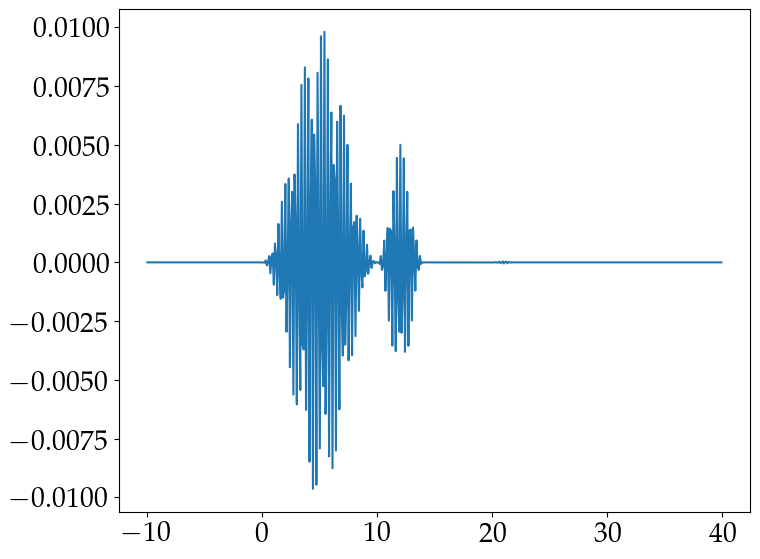

In [15]:
### Test 
params_default = SystemParameters()
params_default.__post_init__()  # Initialize operators and lists
params_default.update_derived()
params_default.t_max = 10
params_default.fine_spacing = 1
print(params_default)
t_max_test = 0.1*params_default.t_max # -> determines Δω
fine_spacing_test = params_default.fine_spacing # -> determines ω_max
print("fine_spacing", fine_spacing_test, "[fs]")

test_Delta_ts = params_default.Delta_ts
times_test = np.arange(-test_Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))
long_times = np.arange(-test_Delta_ts[0], 20*t_max_test, 10*fine_spacing_test)


pulse_test = PulseSequence([
    Pulse(0.0, 5.0, 0.0, 0.2, 16000.0),
    Pulse(10.0, 2.0, np.pi/2, 0.1, 16000.0),
    Pulse(20.0, 1.0, np.pi, 0.001, 16000.0)
])

y2 = El_field_3_pulses(test_times, pulse_test, f=Epsilon_pulse)
plt.plot(test_times, np.real(y2), label="Envelope")



#  TODO ALWAYS CHECK Before running a serious simulation
result, time_cut = check_the_solver(psi_ini, times_test, params_default)
print("the evolution is actually unphisical after:", time_cut, "fs")

T_wait_test = 1* (times_test[1]- times_test[0])
data_test_0 = compute_two_dimensional_polarization(T_wait_test, phases[0], phases[0], times=times_test,  plot_example=True)
#data_test_1 = compute_many_polarizations(T_wait_test, phases[0], phases[0], times=times_test, N=10, E0=omega_A, Delta=Delta)

In [ ]:
plot_args_freq = dict(                   # (**changeable**) 
    space="freq",                   
    type="real",                    # plot the real part (also "imag", "phase", "abs")
    safe=False,                     # (dont) save the spectrum
    positive=True,                  # only plot the positive spectrum
    use_custom_colormap=True,       # all zeros are white
    section=(                       # focus on the non zero part
        1, 2, # xmin, xmax,
        1, 2, # ymin, ymax
        ),

    # add more options as needed
)

ts, taus, data = data_test_0[0], data_test_0[1], data_test_0[2]
#ts, taus, data, omega_samples = data_test_1[0], data_test_1[1], data_test_1[2], data_test_1[3]

extend_for = (0, 100)
ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
plot_positive_color_map(
    (ts, taus, data),
    type="imag", # because E ~ i*P
    T_wait=T_wait_test, 
    safe=False,
    use_custom_colormap=True,
)

nu_ts, nu_taus, s2d = compute_2d_fft_wavenumber(ts, taus, data)
plot_positive_color_map(
    (nu_ts, nu_taus, s2d),
    T_wait=T_wait_test, 
    **plot_args_freq
)

In [ ]:
def compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times):
    """
    Compute the data for a fixed tau_coh and T_wait.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phi_0 (float): Phase of the first pulse.
        phi_1 (float): Phase of the second pulse.

    Returns:
        tuple: Time values and corresponding data.
    """

    idx_start_0 = 0     
    t_start_0 = times[idx_start_0] # ALWAYS the starting point of the first pulse
    idx_end_0 = np.abs(times - (Delta_ts[0])).argmin()
    idx_start_1 = np.abs(times - (tau_coh - Delta_ts[1])).argmin()
    t_start_1   = times[idx_start_1]  # Start time of the second pulse

    times_0 = times[: idx_start_1 + 1] # definetly not empty except for when T_wait >= t_max
    if times_0.size == 0:
        times_0 = times[:idx_end_0+1]
    # calculate the evolution of the first pulse in the desired range for tau_coh

    pulse_0=(t_start_0, phi_0)
    data_0 = compute_pulse_evolution(psi_ini, times_0, curr=pulse_0)

    rho_1 = data_0.states[idx_start_1]

    idx_end_1 = np.abs(times - (tau_coh + Delta_ts[1])).argmin() # index at which the second pulse ends
    # Take the state (after / also during) the first pulse and evolve it with the second (and potentially overlaped first) pulse

    # select range  ->  to reduce computation time
    idx_start_2 = np.abs(times - (tau_coh + T_wait - Delta_ts[2])).argmin()
    t_start_2 = times[idx_start_2] # the time at which the third pulse starts
    idx_end_2 = np.abs(times - (tau_coh + T_wait + Delta_ts[2])).argmin() # end of the third pulse
    # idx_start_2_0 = np.abs(times - (T_wait - Delta_ts[2])).argmin() # the first time at which the third pulse starts

    times_1 = times[idx_start_1:idx_start_2+1] # like this: also take the overlap into account; 
    
    if times_1.size == 0:
        times_1 = times[idx_start_1:idx_end_1+1]

    # Handle overlapping pulses: If the second pulse starts before the first pulse ends, combine their contributions
    pulse_1=(t_start_1, phi_1)
    data_1 = compute_pulse_evolution(rho_1, times_1, curr=pulse_1, prev=pulse_0)

    idx_start_2_in_times_1 = np.abs(times_1 - (t_start_2)).argmin()
    
    rho_2 = data_1.states[idx_start_2_in_times_1] # == state where the third pulse starts

    times_2 = times[idx_start_2:] # the rest of the evolution (third pulse, potentially overlapped with previouses) # can be empty, if tau_coh + T_wait >= t_max
    # print(len(times), len(times_0), len(times_1), len(times_2))
    if times_2.size == 0:
        times_2 = [times[idx_start_2]]
    # If the second pulse starts before the first pulse ends, combine their contributions
    phi_2 = 0 # FIXED PHASE!
    pulse_f=(t_start_2, phi_2)

    data_f = compute_pulse_evolution(rho_2, times_2, curr=pulse_f, prev=pulse_1, preprev=pulse_0)

    t_det_start_idx_in_times_2 = np.abs(times_2  - (times_2[0] + Delta_ts[2])).argmin() # detection time index in times_2
    t_last_puslse_peak = times_2[t_det_start_idx_in_times_2]
    # only if we are still in the physical regime
    states = data_f.states[t_det_start_idx_in_times_2:]
    t_det_vals = data_f.times[t_det_start_idx_in_times_2:]
    data = np.zeros((len(t_det_vals)), dtype=np.complex64) # might get uncontrollable big!TODO

    #print(t_det_vals[0], t_det_vals[1], t_det_vals[-1], len(t_det_vals))
    
    if RWA_laser:
        states = [
            apply_RWA_phase_factors(state, time, omega=system.omega_laser)
            for state, time in zip(states, t_det_vals)
        ]

    for (t_idx, t_det) in enumerate(t_det_vals):
        if t_det < time_cut:
            data[:] = np.real(expect(Dip_op, states[:]))
    return np.array(t_det_vals) - t_det_vals[0], data
# Plot the data for a fixed tau_coh and T_wait
def plot_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times):
    """Plot the data for a fixed tau_coh and T."""
    t_det_vals, data = compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times)

    plt.figure(figsize=(10, 6))
    plt.plot(t_det_vals, np.real(data), label=r"$|\langle \mu \rangle|$")
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        r"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau$ and $T$ (T=1000, $\tau=300$)"
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def compute_average_fixed_tau_T(tau_coh, T_wait, times, phases):
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phases (list): List of phase values.

    Returns:
        tuple: Time values and averaged data.
    """
    results = []
    for phi_0 in phases:
        for phi_1 in phases:
            try:
                result = compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times=times)
                results.append(result)
            except Exception as e:
                print(f"Error in computation for phi_0={phi_0}, phi_1={phi_1}: {e}")
                raise

    # Average the results
    t_det_vals = results[0][0]  # Time values are the same for all computations
    data_sum = np.zeros_like(results[0][1], dtype=complex)
    for _, data in results:
        data_sum += data
    data_avg = data_sum / len(results)

    return t_det_vals, data_avg

def plot_average_fixed_tau_T(tau_coh, T_wait, times, phases):
    """
    Plot the averaged data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phases (list): List of phase values.

    Returns:
        None
    """
    t_det_vals, data_avg = compute_average_fixed_tau_T(tau_coh, T_wait, times, phases)

    plt.figure(figsize=(10, 6))
    plt.plot(t_det_vals, np.abs(data_avg), label=r"$|\langle \mu \rangle|$", color="C0", linestyle="solid")
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$ (averaged over phases)"
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Test the function and plot the data
t_max_test     = 1900
fine_spacing_test = 20
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)   # High-resolution times array to do the evolutions
tau_coh_test   = 300
T_wait_test    = 1000

#plot_fixed_tau_T(tau_coh_test, T_wait_test, phases[0], phases[1], times=times_test)
plot_average_fixed_tau_T(tau_coh_test, T_wait_test, times_test, phases)

In [ ]:
def for_one_time_calc_phase_comb(T_wait, phases, times, omega_at=omega_A):
    """
    Compute and average the 2D polarization for all phase combinations for one T_wait.
    Args:
        T_wait (float): Waiting time.
        phases (list): List of phase values.
        times (np.ndarray): Time grid for computation.
    Returns:
        np.ndarray: Averaged 2D polarization data for this T_wait.
    """
    results         = []
    for phi1 in phases:
        for phi2 in phases:
            _, _, data = compute_two_dimensional_polarization(T_wait, phi1, phi2, times=times, omega_at=omega_at, plot_example=False)
            results.append(data)
    averaged_data = np.mean(np.stack(results), axis=0)
    return averaged_data

def parallel_process_all_combinations(phases, times_T, times, omega_at=omega_A):
    """
    Compute the averaged 2D polarization for all T_wait in times_T using all phase combinations.
    Args:
        phases (list): List of phase values.
        times_T (np.ndarray): Array of T_wait values.
        times (np.ndarray): Time grid for computation.
    Returns:
        list: List of averaged 2D polarization arrays for each T_wait.
    """
    results = [None] * len(times_T)

    # =============================
    # Parallelize over T_waits using ThreadPoolExecutor
    # =============================
    with ThreadPoolExecutor() as executor:
        future_to_idx = {
            executor.submit(for_one_time_calc_phase_comb, T_wait, phases, times, omega_at): idx
            for idx, T_wait in enumerate(times_T)
        }
        for future in as_completed(future_to_idx):
            idx             = future_to_idx[future]
            try:
                averaged_data = future.result()
            except Exception as exc:
                print(f"T_wait index {idx} generated an exception: {exc}")
                averaged_data = None
            results[idx] = averaged_data

    return results

def parallel_process_all_omega_ats(omega_ats, phases, times_T, times):
    """
    Compute the averaged 2D polarization for all omega_ats and all T_wait in times_T using all phase combinations.
    Args:
        omega_ats (list or np.ndarray): List of omega_A values to use.
        phases (list): List of phase values.
        times_T (np.ndarray): Array of T_wait values.
        times (np.ndarray): Time grid for computation.
    Returns:
        list: List of lists, each containing averaged 2D polarization arrays for each T_wait at each omega_at.
    """
    # =============================
    # Compute results for all omega_ats
    # =============================
    all_results = []
    for omega_at in omega_ats:
        results = parallel_process_all_combinations(phases, times_T, times, omega_at=omega_at)
        all_results.append(results)

    # =============================
    # Average over omega_ats for each T_wait
    # =============================
    # all_results: shape (len(omega_ats), len(times_T))
    averaged_results = []
    for t_idx in range(len(times_T)):
        # Collect the t_idx-th result from each omega_at
        data_for_t = [all_results[o_idx][t_idx] for o_idx in range(len(omega_ats))]
        # Average over omega_ats
        averaged_data = np.mean(np.stack(data_for_t), axis=0)
        averaged_results.append(averaged_data)

    return averaged_results

def run_parallel_for_sampled_omegas(N, Delta, E0, phases, times_T, times, sigma=1.0, E_range=10):
    """
    Sample omega_ats using sample_from_sigma and run parallel_process_all_omega_ats.

    Args:
        N (int): Number of samples.
        Delta (float): Energy splitting parameter.
        E0 (float): Central energy.
        phases (list): List of phase values.
        times_T (np.ndarray): Array of T_wait values.
        times (np.ndarray): Time grid for computation.
        sigma (float, optional): Standard deviation for sampling. Default is 1.0.
        E_range (float, optional): Range for sampling. Default is 10.

    Returns:
        list: Averaged 2D polarization arrays for each T_wait, averaged over sampled omegas.
    """
    omega_ats = sample_from_sigma(N, Delta, E0, sigma=sigma, E_range=E_range)
    averaged_results = parallel_process_all_omega_ats(omega_ats, phases, times_T, times)
    return averaged_results

def extend_and_plot_results(averaged_results, times_T, times, extend_for=None, **plot_args_freq):
    global_ts, global_taus = get_tau_cohs_and_t_dets_for_T_wait(times, times_T[0])
    global_data_time = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    if extend_for is not None:
        global_ts, global_taus, global_data_time = extend_time_tau_axes(global_ts, global_taus, global_data_time, pad_rows=extend_for, pad_cols=extend_for)

    global_nu_ts, global_nu_taus, _ = compute_2d_fft_wavenumber(global_ts, global_taus, np.zeros((len(global_ts), len(global_taus))))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    # =============================
    # Combine all data arrays into global arrays for time and frequency domains
    # =============================

    # Initialize global arrays with zeros
    # global_ts and global_taus are the largest axes (from the first T_wait)
    # global_data_time and global_data_freq are already initialized above

    def find_closest_index(local_vals, global_vals):
        """Find indices in global_vals closest to each value in local_vals."""
        return [np.argmin(np.abs(global_vals - v)) for v in local_vals]

    for (i, data) in enumerate(averaged_results):
        T_wait = times_T[i]
        ts, taus = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)
        if extend_for is not None:
            ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
        nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, data)

        # Map local data into the global arrays
        tau_indices = find_closest_index(taus, global_taus)
        t_indices   = find_closest_index(ts, global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                # Check bounds before assignment to avoid IndexError
                if global_tau_idx < global_data_time.shape[0] and global_t_idx < global_data_time.shape[1]:
                    global_data_time[global_tau_idx, global_t_idx] += data[local_tau_idx, local_t_idx]
                    global_data_freq[global_tau_idx, global_t_idx] += data_freq[local_tau_idx, local_t_idx]
                else:
                    # Print debug info if index is out of bounds
                    print(f"IndexError: global_tau_idx={global_tau_idx}, global_t_idx={global_t_idx}, shape={global_data_time.shape}")
        """plot_positive_color_map(
            (ts, taus, data), 
            times_T[i], 
            type="imag",
            use_custom_colormap=True,
            )

        plot_positive_color_map(
            (nu_ts, nu_taus, data_freq),
            times_T[i],
            **plot_args_freq
        )"""


    # Normalize by number of T_waits
    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)

    # Plot the global results
    plot_positive_color_map(
        (global_ts, global_taus, global_data_time),
        type="imag",
        use_custom_colormap=True,
    )
    plot_positive_color_map(
        (global_nu_ts, global_nu_taus, global_data_freq),
        **plot_args_freq
    )

In [ ]:
# Test the function and plot the data
t_max_test     = 100 # -> determines Δω
fine_spacing_test = 0.1 # -> determines ω_max
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))
times_T_test = (np.array([0])# , 16, 30, 46, 62, 108, 140, 310])
)  # np.arange(T_wait_0, last_entry, sparse_spacing)

RESULT = parallel_process_all_combinations(phases ,times_T=times_T_test, times=times_test)

In [ ]:
# Example usage
extend_and_plot_results(RESULT, times_T=times_T_test, times=times_test, extend_for=extend_for, **plot_args_freq)